In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#Get column names in measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Get column names in station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement= Base.classes.measurement
Station=Base.classes.station


In [11]:
# Create our session (link) from Python to the DB
session= Session(engine)


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#last_date 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("One Year Ago from last date reported is: ", one_year_ago)


One Year Ago from last date reported is:  2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
precip_list= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_ago)


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
connection=engine.connect()
precip= pd.read_sql_query(precip_list.statement,connection).sort_values("date").set_index("date")
precip


prcp
date            
2016-08-23  0.00
2016-08-23   NaN
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15
...          ...
2017-08-22  0.00
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2230 rows x 1 columns]

In [15]:
avg_rainfall= precip.groupby("date")
# dates_grouped= precip.mean()
# dates_grouped
# dates= precip["date"].unique()
# dates
avg_rainfall_date=avg_rainfall["prcp"].mean()
avg_rainfall_date

date
2016-08-23    0.451667
2016-08-24    1.555000
2016-08-25    0.077143
2016-08-26    0.016667
2016-08-27    0.064000
                ...   
2017-08-19    0.030000
2017-08-20    0.005000
2017-08-21    0.193333
2017-08-22    0.166667
2017-08-23    0.132500
Name: prcp, Length: 366, dtype: float64

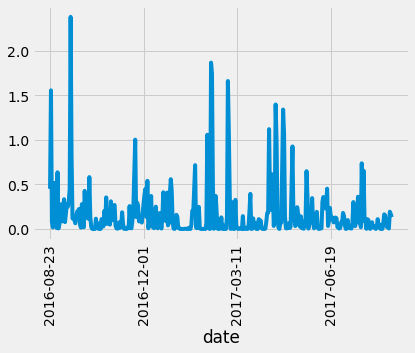

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

avg_rainfall_date.plot(x="date", y="prcp", rot=90)


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_data= precip.agg(["mean", "median", "var", "std", "sem"]).round(decimals=2)
precip_data

prcp
mean    0.18
median  0.02
var     0.21
std     0.46
sem     0.01

In [18]:
# Design a query to show how many stations are available in this dataset?
station_list= session.query(Station.station).count()
print(station_list)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temperature= session.query(func.min(Measurement.tobs).filter(Measurement.station=='USC00519281')).all()
print(f"The lowest temperature at the most active station is {lowest_temperature[0][0]}.")

The lowest temperature at the most active station is 54.0.


In [40]:
highest_temperature= session.query(func.max(Measurement.tobs).filter(Measurement.station=='USC00519281')).all()
                                   
avg_temperature= session.query(func.avg(Measurement.tobs).filter(Measurement.station=='USC00519281')).all()
                               
print(f"The highest temperature at the most active station is {highest_temperature[0][0]}.")                           
print(f"The average temperature at the most active station is {avg_temperature[0][0]}.")

                               

The highest temperature at the most active station is 85.0.
The average temperature at the most active station is 71.66378066378067.


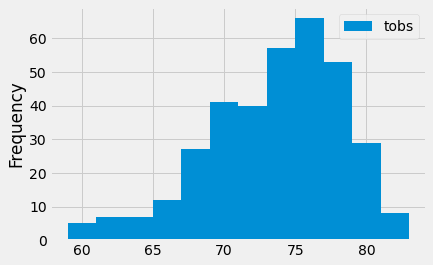

In [57]:
# Choose the station with the highest number of temperature observations.
highest_temp_station= session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date>=one_year_ago).all()
highest_temp_station                                    
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df=pd.DataFrame(highest_temp_station, columns=["tobs"])
temp_df

temp_df.plot.hist(bins=12)


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
